# Sentiment Analysis on News Articles
Now that the data has been cleaned, we can proceed with trying to train a classifier. The general plan is to use word embeddings from a Word2Vec model to represent the text for each article, then use a many-to-one recurrent neural network to predict the sentiment of these articles.

In [91]:
import time
import re
import os
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import gensim.models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Processing the Headlines and Descriptions

In [2]:
articles = pd.read_csv('./data/cleaned_articles.csv')

Before begin, let's shuffle our articles dataframe and divide it into training, validation, testing sets. We'll allocate 80% of the data for training, 10% for validation, and the remaining 10% for testing.

In [123]:
shuffled_articles = articles.sample(frac = 1)
num_articles = len(articles)
num_val = int(0.1 * num_articles)

train_df = shuffled_articles.iloc[2 * num_val:]
val_df = shuffled_articles.iloc[num_val: 2 * num_val]
test_df = shuffled_articles.iloc[:num_val]

output = 'Total: {} | Train: {} | Val: {} | Test: {}'
print(output.format(num_articles, len(train_df), len(val_df), len(test_df)))

Total: 11877 | Train: 9503 | Val: 1187 | Test: 1187


For reproducibility, we'll save the train/test split to csv files.

In [124]:
train_df.to_csv('data/train_split.csv', index = False)
val_df.to_csv('data/val_split.csv', index = False)
test_df.to_csv('data/test_split.csv', index = False)

In [125]:
train_df = pd.read_csv('data/train_split.csv')
val_df = pd.read_csv('data/val_split.csv')
test_df = pd.read_csv('data/test_split.csv')

Right now, the headlines and descriptions are two separate sequences of words that we can't directly analyze. To make things easier, let's concatenate the headlines and descriptions into one block of text so we can treat them as one sequence for the RNN to analyze.

In [19]:
def add_combined_column(dataframe, columns):
    '''For each article in the dataframe, concatenate the headline and description into a combined entry,
    ignoring NaN entries.
    Arguments:
        dataframe {pd.DataFrame} -- DataFrame to which the combined column will be added
        columns {tuple} -- tuple of strings that indicate the two categories to combine to form 'combined'
    '''
    for i, row in dataframe.iterrows():
        headline, description = row[columns[0]], row[columns[1]]
        combined = ""
        
        if type(headline) == str:
            combined += headline
        elif type(description) == str:
            combined += description
            
        dataframe.loc[i, 'combined'] = combined

To make sure that our functions work (and to visualize the results), we'll apply the functinos to the `articles` dataframe after each step.

In [7]:
add_combined_column(articles, ('headline', 'description'))
articles.head()

,headline,url,description,category,source,combined
0,"A Sad Bulldog, A Happy Prince And More Things ...",https://www.huffpost.com/entry/coronavirus-dis...,"A sad bulldog and a happy, paint-covered princ...",good,huffpost,"A Sad Bulldog, A Happy Prince And More Things ..."
1,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...,https://www.huffpost.com/entry/john-krasinski-...,"""The Office"" star struck gold again in his You...",good,huffpost,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...
2,I Was Struggling As A Single Mom. Then A Stran...,https://www.huffpost.com/entry/struggling-sing...,"""With this gift, I was finally able to get out...",good,huffpost,I Was Struggling As A Single Mom. Then A Stran...
3,Pink's Advice To Fans: 'Change The F**king Wor...,https://www.huffpost.com/entry/pink-peoples-ch...,“I care about decency and humanity and kindnes...,good,huffpost,Pink's Advice To Fans: 'Change The F**king Wor...
4,10 Books For Parents Who Want To Raise Kind Kids,https://www.huffpost.com/entry/parenting-books...,These parenting books emphasize emotional inte...,good,huffpost,10 Books For Parents Who Want To Raise Kind Kids


Nice! Before we can represent this new 'combined' entry as a matrix, we have to remove punctuation / special characters and numbers, since they don't convey much meaningful information about sentiment and could bog down the model.

In [8]:
def process_text(text):
    text = text.lower()
    # remove any non alphanumeric characters,
    # escaping ' and * because of contractions and swear censorship
    text = re.sub(r"[^a-zA-Z'\*]", " ", text)
    # tokenize the combined text by splitting on spaces and removing whitespace
    text = text.split()
    word_list = []
    for i, word in enumerate(text):
        # remove any censored swears which would likely just waste space in the w2v model
        if '*' in word:
            continue
        # remove any artifact of the regex checking that leaves a single apostrophe as a 'word'
        elif word == "'":
            continue
        # remove single-quoted text by checking for first character apostrophes then last character apostrophes
        word = re.sub(r"^'", "", word)
        word = re.sub(r"'$", "", word)
        
        # removing 's possessives
        word = re.sub(r"'s$", "", word)
        word_list.append(word)
        
    return word_list

In [9]:
articles['processed'] = articles['combined'].apply(process_text)
articles.head()

,headline,url,description,category,source,combined,processed
0,"A Sad Bulldog, A Happy Prince And More Things ...",https://www.huffpost.com/entry/coronavirus-dis...,"A sad bulldog and a happy, paint-covered princ...",good,huffpost,"A Sad Bulldog, A Happy Prince And More Things ...","[a, sad, bulldog, a, happy, prince, and, more,..."
1,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...,https://www.huffpost.com/entry/john-krasinski-...,"""The Office"" star struck gold again in his You...",good,huffpost,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...,"[john, krasinski, shocks, year, old, hamilton,..."
2,I Was Struggling As A Single Mom. Then A Stran...,https://www.huffpost.com/entry/struggling-sing...,"""With this gift, I was finally able to get out...",good,huffpost,I Was Struggling As A Single Mom. Then A Stran...,"[i, was, struggling, as, a, single, mom, then,..."
3,Pink's Advice To Fans: 'Change The F**king Wor...,https://www.huffpost.com/entry/pink-peoples-ch...,“I care about decency and humanity and kindnes...,good,huffpost,Pink's Advice To Fans: 'Change The F**king Wor...,"[pink, advice, to, fans, change, the, world]"
4,10 Books For Parents Who Want To Raise Kind Kids,https://www.huffpost.com/entry/parenting-books...,These parenting books emphasize emotional inte...,good,huffpost,10 Books For Parents Who Want To Raise Kind Kids,"[books, for, parents, who, want, to, raise, ki..."


Now that the data is combined and processed, we'll just transform the 'category' column into a `torch.Tensor` label from 0 to 3 that we'll use later on when training our RNN model.

In [10]:
def get_label(category):
    if category == 'bad':
        label = 0
    elif category == 'neutral':
        label = 1
    elif category == 'good':
        label = 2
    else:
        print(f"Expected 'good', 'bad', or 'neutral' for category for article. Found: {category}.")
        return None
    label = torch.tensor(label, dtype = torch.long)
    return label

In [11]:
articles['label'] = articles['category'].apply(get_label)
articles.head()

,headline,url,description,category,source,combined,processed,label
0,"A Sad Bulldog, A Happy Prince And More Things ...",https://www.huffpost.com/entry/coronavirus-dis...,"A sad bulldog and a happy, paint-covered princ...",good,huffpost,"A Sad Bulldog, A Happy Prince And More Things ...","[a, sad, bulldog, a, happy, prince, and, more,...",tensor(2)
1,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...,https://www.huffpost.com/entry/john-krasinski-...,"""The Office"" star struck gold again in his You...",good,huffpost,John Krasinski Shocks 9-Year-Old 'Hamilton' Fa...,"[john, krasinski, shocks, year, old, hamilton,...",tensor(2)
2,I Was Struggling As A Single Mom. Then A Stran...,https://www.huffpost.com/entry/struggling-sing...,"""With this gift, I was finally able to get out...",good,huffpost,I Was Struggling As A Single Mom. Then A Stran...,"[i, was, struggling, as, a, single, mom, then,...",tensor(2)
3,Pink's Advice To Fans: 'Change The F**king Wor...,https://www.huffpost.com/entry/pink-peoples-ch...,“I care about decency and humanity and kindnes...,good,huffpost,Pink's Advice To Fans: 'Change The F**king Wor...,"[pink, advice, to, fans, change, the, world]",tensor(2)
4,10 Books For Parents Who Want To Raise Kind Kids,https://www.huffpost.com/entry/parenting-books...,These parenting books emphasize emotional inte...,good,huffpost,10 Books For Parents Who Want To Raise Kind Kids,"[books, for, parents, who, want, to, raise, ki...",tensor(2)


Great! Now, let's combine those steps into one `preprocess()` function that we can apply to our `train_df` and `test_df`.

In [12]:
def preprocess_articles(*dataframes):
    for dataframe in dataframes:
        add_combined_column(dataframe, ('headline', 'description'))
        dataframe['processed'] = dataframe['combined'].apply(process_text)
        dataframe['label'] = dataframe['category'].apply(get_label)

In [131]:
preprocess_articles(train_df, val_df, test_df)
train_df.head()

,headline,url,description,category,source,combined,processed,label
0,"LA County Cops Fire at Pit Bull, Kill Teenager",https://www.newser.com/story/244699/la-county-...,17-year-old had been trying to restrain animal,bad,newser,"LA County Cops Fire at Pit Bull, Kill Teenager","[la, county, cops, fire, at, pit, bull, kill, ...",tensor(0)
1,When Family Can’t Afford Motorized Wheelchair ...,https://www.goodnewsnetwork.org/when-family-ca...,A team of tenacious robotics students have cha...,good,goodnewsnetwork,When Family Can’t Afford Motorized Wheelchair ...,"[when, family, can, t, afford, motorized, whee...",tensor(2)
2,Woman Who Visited and Fed Chained-Up Dog for a...,https://www.goodnewsnetwork.org/woman-who-visi...,Laura Seymour visited and fed this neglected p...,good,goodnewsnetwork,Woman Who Visited and Fed Chained-Up Dog for a...,"[woman, who, visited, and, fed, chained, up, d...",tensor(2)
3,Newborn Found Buried Alive,https://www.newser.com/story/216766/newborn-fo...,Two sisters hear baby crying while taking a walk,bad,newser,Newborn Found Buried Alive,"[newborn, found, buried, alive]",tensor(0)
4,Patton Oswalt: Grief Over My Wife's Death 'Is ...,https://www.newser.com/story/233161/patton-osw...,Comedian offers heartbreaking glimpse into lif...,bad,newser,Patton Oswalt: Grief Over My Wife's Death 'Is ...,"[patton, oswalt, grief, over, my, wife, death,...",tensor(0)


## Creating and Training the Word2Vec Model

Let's initialize a Word2Vec Model with 300-dimensional word vectors and a subsampling parameter of 1e-5, since [Mikolov et al](https://arxiv.org/pdf/1310.4546.pdf) achieved good results with these settings.

In [214]:
EMBEDDING_DIM = 50
w2v_model = gensim.models.Word2Vec(size = EMBEDDING_DIM, sample=1e-5)

I pulled two pre-existing datasets, [one](https://www.kaggle.com/therohk/million-headlines) of ABC news headlines and the [other](https://www.kaggle.com/snapcrack/all-the-news) from 15 news organizations. We can add these two to the dataset I assembled to give our model as robust and wide a vocabulary as possible.

In [15]:
abc_headlines = pd.read_csv('./data/external/abc_articles.csv')
abc_headlines.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [209]:
all_the_news_path = r'./data/external/All the News'
ATN_csv_files = glob.glob(os.path.join(all_the_news_path, '*.csv')) # ATN: All the News
ATN_articles = pd.concat((pd.read_csv(file) for file in ATN_csv_files))
ATN_articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


Let's just keep the titles and contents of the `ATN_articles`.

In [210]:
ATN_articles = ATN_articles.loc[:, ['id', 'title', 'content']]
ATN_articles.dropna(inplace = True)

We'll process the headlines using our previous `process_text()` function so that the Word2Vec model can input them.

In [35]:
abc_headlines['processed'] = abc_headlines['headline_text'].apply(process_text)
abc_headlines.head()

,publish_date,headline_text,processed
0,20030219,aba decides against community broadcasting lic...,"[aba, decides, against, community, broadcastin..."
1,20030219,act fire witnesses must be aware of defamation,"[act, fire, witnesses, must, be, aware, of, de..."
2,20030219,a g calls for infrastructure protection summit,"[a, g, calls, for, infrastructure, protection,..."
3,20030219,air nz staff in aust strike for pay rise,"[air, nz, staff, in, aust, strike, for, pay, r..."
4,20030219,air nz strike to affect australian travellers,"[air, nz, strike, to, affect, australian, trav..."


In [211]:
ATN_articles['processed_title'] = ATN_articles['title'].apply(process_text)
ATN_articles['processed_content'] = ATN_articles['content'].apply(process_text)
ATN_articles.head()

,id,title,content,processed_title,processed_content
0,17283,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,"[house, republicans, fret, about, winning, the...","[washington, congressional, republicans, have,..."
1,17284,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood...","[rift, between, officers, and, residents, as, ...","[after, the, bullet, shells, get, counted, the..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri...","[tyrus, wong, bambi, artist, thwarted, by, rac...","[when, walt, disney, s, bambi, opened, in, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t...","[among, deaths, in, a, heavy, toll, in, pop, m...","[death, may, be, the, great, equalizer, but, i..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ...","[kim, jong, un, says, north, korea, is, prepar...","[seoul, south, korea, north, korea, s, leader,..."


The Gensim Word2Vec model can't input `pd.DataFrame` or `pd.Series` objects, so let's convert the 'processed' `pd.Series` from each dataframe into a list of entries.

In [212]:
abc_rows = abc_headlines['processed'].to_list()

ATN_title_rows = ATN_articles['processed_title'].to_list()

ATN_content_rows = ATN_articles['processed_content'].to_list()

article_rows = articles['processed'].to_list()

combined_rows = abc_rows + article_rows + ATN_title_rows + ATN_content_rows

Now, we can build the vocabulary of the model.

In [215]:
start = time.time()

w2v_model.build_vocab(combined_rows, min_count = 1)

current = time.time()
elapsed = (current - start) / 60
print('Time to build vocab: {} mins'.format(round(elapsed, 2)))

Time to build vocab: 2.23 mins


Then, train it on the *combined* rows because the more data we have here, the better the model will be able to discern the relationships between the words. The sentiment classification will be done by the RNN later, so for right now we just want the best embeddings we can get.

In [216]:
start = time.time()

w2v_model.train(
    combined_rows, 
    total_examples = w2v_model.corpus_count, 
    epochs = 50)

current = time.time()
elapsed = (current - start) / 60
print('Time to train model: {} mins'.format(round(elapsed, 2)))

w2v_model.save('./models/w2v')

Time to train model: 64.01 mins


Checkpoint for `w2v_model`. Run if you'd like to play with the model without waiting for it to train!

In [40]:
w2v_model = gensim.models.Word2Vec.load('./models/w2v')

Time to sanity check the model.

In [219]:
w2v_model.wv.most_similar('obama')

[('barack', 0.9670791029930115),
 ('president', 0.8825982809066772),
 ('administration', 0.83634352684021),
 ('bush', 0.7738842964172363),
 ('presidency', 0.761516809463501),
 ('trump', 0.7546470165252686),
 ('predecessor', 0.7356011271476746),
 ('donald', 0.7262818813323975),
 ('incoming', 0.697263240814209),
 ('vowed', 0.6782877445220947)]

Looks like it did alright!

## Model Creation
To predict the sentiment of the text, we'll use a many-to-one LSTM. The hidden state of the LSTM should allow us to pick up long-term negations and other constructions that can affect the sentiment.

In [229]:
class SentimentClassifier(nn.Module):
    def __init__(self, word_vectors, hidden_size, num_layers = 1):
        '''
        Arguments:
            input_size {int} -- number of input features to be expected
            hidden_size {int} -- number of features in the hidden state
            word_vectors {gensim.models.keyedvectors.Word2VecKeyedVectors} -- trained word vectors to embed sentences
        '''
        super(SentimentClassifier, self).__init__()
        
        self.word_vectors = word_vectors
        self.hidden_size = hidden_size
        self.GRU = nn.GRU(input_size = EMBEDDING_DIM,
                            hidden_size = self.hidden_size,
                            num_layers = num_layers)
        # 3 is the number of classes (good, neutral, negative)
        self.linear = nn.Linear(hidden_size, 3)
        
    def embed(self, news_text):
        '''Inputs the processed news text, then embeds all words in the vocabulary of the word vectors.'''
        word_tensors = []
        for word in news_text:
            try:
                word_vector = self.word_vectors.get_vector(word)
                word_torch_tensor = torch.from_numpy(word_vector)
                word_tensors.append(word_torch_tensor)
            # if the word doesn't haven an embedding, a KeyError is thrown
            except KeyError as e:
                print(e, 'Ignoring word.')
                pass
        # convert the list of tensors into one long tensor with shape (# of words, EMBEDDING_DIM)
        article_tensor = torch.stack(word_tensors)
        # self.LSTM expects the input tensor to be in format (# of words, batch_size, EMBEDDING_DIM)
        article_tensor = article_tensor.view(len(article_tensor), 1, EMBEDDING_DIM)
        article_tensor = article_tensor.to(device)
        return article_tensor

    def forward(self, news_text):
        embedded_text = self.embed(news_text)
        '''The first value returned below is a tensor of the outputs from all timesteps. 
        Since we only need the output of the final layer, we can ignore it. 
        The second value, output, is the desired hidden state from the final timestep.'''
        _, output = self.GRU(embedded_text)
        # the output has a shape of (num_layers, batch_size, hidden_size)
        # the outputs from previous layers aren't important, 
        # so take the output of the final layer of the LSTM (the first index in lstm_output)
        output = output[0]
        # transform the output to shape (batch_size, 3) where 3 is the number of classes
        output = self.linear(output)
        return output

Let's test to see if the model does what we want. Since there are three classes, we should see a tensor with shape (3,) returned.

In [255]:
model = SentimentClassifier(word_vectors = w2v_model.wv, hidden_size = 5)

In [256]:
test_output = model(articles.loc[0, 'processed'])
print(test_output)

tensor([[ 0.4678, -0.1807,  0.1423]], grad_fn=<AddmmBackward>)


Great!

## Training
Before we can train the model, we'll need to convert the 'processed' and 'label' columns from the `articles` dataframe into torch `Dataset` so it can be used in a `DataLoader` during the training process.

In [78]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, articles_dataframe):
        self.articles_dataframe = articles_dataframe
    
    def __getitem__(self, index):
        (text, label) = self.articles_dataframe.loc[index, ['processed', 'label']]
        # the loss function will expect the label to be of shape (batch_size)
        label = label.view(1)
        item = {'text': text, 'label': label}
        return item
    
    def __len__(self):
        return len(self.articles_dataframe)

Now, we'll instantiate `NewsDataset` objects for the training and testing sets so that we can then create `DataLoader` objects.

In [155]:
train_dataset = NewsDataset(train_df)
val_dataset = NewsDataset(val_df)

test_dataset = NewsDataset(test_df)

The torch `DataLoader` seems to convert the 'text' entry in the `NewsDataset` from a list of strings into a list of tuples of strings. To avoid that, we'll define a custom collate function and batch format, which will just return the text (list of strings) and the label (`torch.Tensor`) as they are.

In [80]:
class CustomBatch:
    def __init__(self, data):
        # the DataLoader returns the NewsDataset item in a list, since it's technically a batch
        # our batch size is 1, so we'll just take the only entry in the list and move on
        data = data[0]
        self.text = data['text']
        self.label = data['label']

def collate_wrapper(batch):
    return CustomBatch(batch)

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, collate_fn = collate_wrapper)
val_loader = torch.utils.data.DataLoader(val_dataset, collate_fn = collate_wrapper)

test_loader = torch.utils.data.DataLoader(test_dataset, collate_fn = collate_wrapper)

In [132]:
example_batch = next(iter(train_loader))
example_batch.text, example_batch.label

(['la', 'county', 'cops', 'fire', 'at', 'pit', 'bull', 'kill', 'teenager'],
 tensor([0]))

Next, let's define our loss function and optimizer. Since the task is now a multi-class classification problem, we'll use the CrossEntropy loss function.

In [257]:
LEARNING_RATE = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE)

At this point, we've now assembled, cleaned, and processed the data, created a set of word embeddings, and initialized our model. We're ready to train!

In [258]:
def evaluate(input_model, loader, print_ = False):
    input_model.eval()
    running_loss = 0
    correct = 0
    with torch.no_grad():
        for item in loader:
            text, label = item.text, item.label
            output = input_model(text)

            running_loss += criterion(output, label)
            pred = output.argmax()

            if label == pred:
                correct += 1

    avg_loss = running_loss / len(test_loader)
    accuracy = (100. * correct) / len(test_loader)
    if print_:
        output_msg = 'Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'
        print(output_msg.format(avg_loss, correct, len(test_loader), accuracy))
    return avg_loss, accuracy

In [259]:
EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for item in train_loader:
        model.zero_grad()
        text, label = item.text, item.label
        output = model(text)
        loss = criterion(output, label)
        running_loss += loss
        
        loss.backward()
        optimizer.step()
    
    val_loss, val_accuracy = evaluate(model, val_loader)
    val_losses.append(val_loss)
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    output_msg = 'Epoch: {} | Train Loss: {:.4f} | Val Loss: {:.4f} | Val Accuracy: {:.1f}%'
    print(output_msg.format(epoch, avg_loss, val_loss, val_accuracy))

Epoch: 0 | Train Loss: 0.5783 | Val Loss: 0.4560 | Val Accuracy: 83.4%
Epoch: 1 | Train Loss: 0.3996 | Val Loss: 0.4058 | Val Accuracy: 84.8%
Epoch: 2 | Train Loss: 0.3619 | Val Loss: 0.3755 | Val Accuracy: 86.2%
Epoch: 3 | Train Loss: 0.3348 | Val Loss: 0.3565 | Val Accuracy: 86.4%
Epoch: 4 | Train Loss: 0.3193 | Val Loss: 0.3476 | Val Accuracy: 86.4%
Epoch: 5 | Train Loss: 0.3109 | Val Loss: 0.3544 | Val Accuracy: 87.3%
Epoch: 6 | Train Loss: 0.3051 | Val Loss: 0.3570 | Val Accuracy: 86.9%
Epoch: 7 | Train Loss: 0.3004 | Val Loss: 0.3458 | Val Accuracy: 87.1%
Epoch: 8 | Train Loss: 0.2998 | Val Loss: 0.3570 | Val Accuracy: 87.0%
Epoch: 9 | Train Loss: 0.2956 | Val Loss: 0.3554 | Val Accuracy: 87.3%
Epoch: 10 | Train Loss: 0.2927 | Val Loss: 0.3536 | Val Accuracy: 87.6%
Epoch: 11 | Train Loss: 0.2900 | Val Loss: 0.3490 | Val Accuracy: 88.0%
Epoch: 12 | Train Loss: 0.2865 | Val Loss: 0.3417 | Val Accuracy: 88.2%
Epoch: 13 | Train Loss: 0.2860 | Val Loss: 0.3492 | Val Accuracy: 88.1%
Ep

KeyboardInterrupt: 

In [243]:
train_losses_plot = [tensor.cpu().detach().numpy() for tensor in train_losses]
val_losses_plot = [tensor.cpu().detach().numpy() for tensor in val_losses]

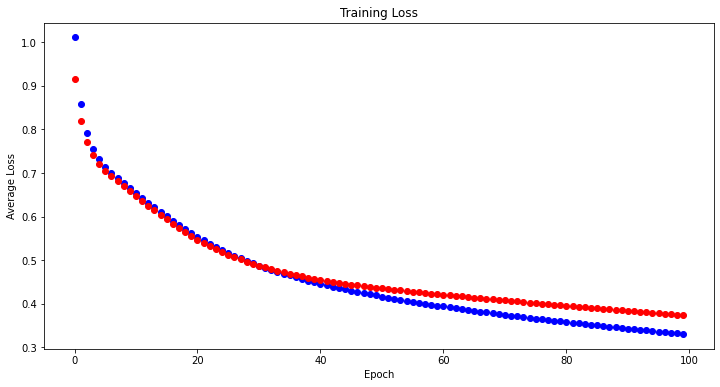

In [244]:
plt.figure(figsize=(12,6))
plt.scatter(range(100), train_losses_plot, c = 'blue')
plt.scatter(range(100), val_losses_plot, c = 'red')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.xticks(np.arange(100), np.arange(100))
plt.title('Training Loss')
plt.show()

In [202]:
example_sentence = ['covid', 'vaccine', 'found', 'public', 'rejoice']

In [203]:
nn.Softmax(dim = 1)(model(example_sentence))

tensor([[0.3815, 0.0522, 0.5662]], grad_fn=<SoftmaxBackward>)

In [68]:
torch.tensor([[0.2811, 0.1574, 0.0317]]).argmax()

tensor(0)